Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os,shutil
import pandas as pd
import keras
from keras.layers import *
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.models import load_model
from PIL import Image
!pip install transformers
from transformers import ViTFeatureExtractor, ViTModel
from PIL import ImageFile
from tqdm import tqdm
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve,classification_report
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.4 MB/s eta 0:00:00


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

**Train Data**

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
from timm import create_model

In [ ]:
def deit():
  # Load a pre-trained DEiT model
  model_name = 'deit_base_patch16_224'
  num_classes = 1000
  model = create_model(
      model_name,
      pretrained=True,
      num_classes=num_classes,
      drop_rate=0.0,
  )

  # Remove the classification head
  model = torch.nn.Sequential(*list(model.children())[:-1])

  # Set the model to evaluation mode
  model.eval()

  # Define the image transformation pipeline
  transform = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      ),
  ])

  # Load an example image
  img_path = '/content/drive/MyDrive/first_third-400/Train/first/0000816_20210106_OBST-_2ND-_TRIM_0001_1.JPG'
  img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)

  # Extract features from the image
  with torch.no_grad():
      features = model(img)
      features_np = features.numpy()[0]

      features_tensor = torch.from_numpy(features_np)
      features_mean = torch.mean(features_tensor, dim=0)

  # Print the size of the feature tensor
  print(features_mean.size())


In [ ]:
deit()

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


torch.Size([768])


In [ ]:
%cd /content/drive/MyDrive/first_third-400/Train/first/
path= '/content/drive/MyDrive/first_third-400/Train/first'
files=os.listdir(path)
image_name=[]
lhs=[]
category=[]
for filename in tqdm(files):
  image_name.append(filename)
  category.append('first')
  image = Image.open(filename)
  image=image.convert('RGB')
  feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
  model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
  inputs = feature_extractor(image, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden_states = torch.squeeze(outputs.pooler_output)#torch.squeeze(torch.unsqueeze(torch.tensor(np.average(torch.squeeze(outputs.last_hidden_state),axis=0)),1))
  lhs.append(last_hidden_states)

/content/drive/MyDrive/first_third-400/Train/first


  0%|          | 0/280 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


100%|██████████| 280/280 [09:05<00:00,  1.95s/it]


In [ ]:
lhs[0].size()

torch.Size([768])

In [ ]:
%cd

/root


In [ ]:
%cd /content/drive/MyDrive/first_third-400/Train/third/
path= '/content/drive/MyDrive/first_third-400/Train/third'
files=os.listdir(path)
# image_name=[]
# lhs=[]
# category=[]
for filename in tqdm(files):
  image_name.append(filename)
  category.append('third')
  image = Image.open(filename)
  image=image.convert('RGB')
  feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
  model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
  inputs = feature_extractor(image, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden_states = torch.squeeze(outputs.pooler_output)#torch.squeeze(torch.unsqueeze(torch.tensor(np.average(torch.squeeze(outputs.last_hidden_state),axis=0)),1))
  lhs.append(last_hidden_states)

/content/drive/MyDrive/first_third-400/Train/third


100%|██████████| 280/280 [08:07<00:00,  1.74s/it]


In [ ]:
lhs[0].size()

torch.Size([768])

In [ ]:
train=pd.DataFrame(list(zip(image_name,lhs,category)),columns=["Image_Name","Vectors","Category"])
train.head()

,Image_Name,Vectors,Category
0,0024663_20200313_OBS-_GEN_0005_1.JPG,"[tensor(0.8419), tensor(0.0562), tensor(-0.688...",first
1,0024663_20200313_OBS-_GEN_0002_1.JPG,"[tensor(0.6299), tensor(-0.0302), tensor(-0.62...",first
2,0024663_20200313_OBS-_GEN_0004_1.JPG,"[tensor(0.6460), tensor(-0.0342), tensor(-0.59...",first
3,019019_20200316_OBST-_EARLY-__0001_1.JPG,"[tensor(0.4507), tensor(-0.0380), tensor(-0.36...",first
4,0024663_20200313_OBS-_GEN_0006_1.JPG,"[tensor(0.7571), tensor(-0.1527), tensor(-0.34...",first


In [ ]:
vector=[]
for i in range(1,769):
    vector.append("Vector_"+str(i))

In [ ]:
split_result = pd.DataFrame(train["Vectors"].tolist(), columns=vector)
split_result=split_result.astype(float)
split_result.head()

,Vector_1,Vector_2,Vector_3,Vector_4,Vector_5,Vector_6,Vector_7,Vector_8,Vector_9,Vector_10,...,Vector_759,Vector_760,Vector_761,Vector_762,Vector_763,Vector_764,Vector_765,Vector_766,Vector_767,Vector_768
0,0.841876,0.056188,-0.688793,0.039628,0.632204,0.564803,0.687121,0.591927,0.057575,0.051838,...,-0.203730,0.275477,-0.653956,0.189222,0.021312,0.017978,-0.262850,0.006381,0.601462,-0.427792
1,0.629869,-0.030243,-0.626261,0.197137,0.000077,0.521777,0.628797,0.551046,0.095684,0.134939,...,-0.574217,0.041518,-0.391420,-0.055388,0.067774,0.438056,-0.485157,-0.407179,0.114872,-0.670205
2,0.645950,-0.034195,-0.594649,0.193005,0.314631,0.405850,0.825064,0.599154,0.233787,0.148275,...,-0.562920,0.148080,-0.699565,0.012810,-0.162367,0.150176,-0.600583,-0.212640,0.249901,-0.585827
3,0.450685,-0.037974,-0.366590,0.366835,0.562404,0.619367,0.328977,0.558770,-0.348318,-0.763137,...,-0.196716,-0.154447,-0.320755,0.462911,-0.122309,-0.214819,-0.151878,0.351127,0.515523,-0.115950
4,0.757144,-0.152723,-0.341908,0.200328,0.240478,0.644106,0.863206,0.458273,0.326465,-0.124699,...,-0.504405,0.050302,-0.501096,0.264562,-0.176726,-0.121188,-0.449138,-0.384292,0.322958,-0.630164


In [ ]:
for i in range(1,769):
    train["Vector_"+str(i)]=split_result["Vector_"+str(i)]
train.head()

<ipython-input-16-a2389bd6eed5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train["Vector_"+str(i)]=split_result["Vector_"+str(i)]
<ipython-input-16-a2389bd6eed5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train["Vector_"+str(i)]=split_result["Vector_"+str(i)]
<ipython-input-16-a2389bd6eed5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

,Image_Name,Vectors,Category,Vector_1,Vector_2,Vector_3,Vector_4,Vector_5,Vector_6,Vector_7,...,Vector_759,Vector_760,Vector_761,Vector_762,Vector_763,Vector_764,Vector_765,Vector_766,Vector_767,Vector_768
0,0024663_20200313_OBS-_GEN_0005_1.JPG,"[tensor(0.8419), tensor(0.0562), tensor(-0.688...",first,0.841876,0.056188,-0.688793,0.039628,0.632204,0.564803,0.687121,...,-0.203730,0.275477,-0.653956,0.189222,0.021312,0.017978,-0.262850,0.006381,0.601462,-0.427792
1,0024663_20200313_OBS-_GEN_0002_1.JPG,"[tensor(0.6299), tensor(-0.0302), tensor(-0.62...",first,0.629869,-0.030243,-0.626261,0.197137,0.000077,0.521777,0.628797,...,-0.574217,0.041518,-0.391420,-0.055388,0.067774,0.438056,-0.485157,-0.407179,0.114872,-0.670205
2,0024663_20200313_OBS-_GEN_0004_1.JPG,"[tensor(0.6460), tensor(-0.0342), tensor(-0.59...",first,0.645950,-0.034195,-0.594649,0.193005,0.314631,0.405850,0.825064,...,-0.562920,0.148080,-0.699565,0.012810,-0.162367,0.150176,-0.600583,-0.212640,0.249901,-0.585827
3,019019_20200316_OBST-_EARLY-__0001_1.JPG,"[tensor(0.4507), tensor(-0.0380), tensor(-0.36...",first,0.450685,-0.037974,-0.366590,0.366835,0.562404,0.619367,0.328977,...,-0.196716,-0.154447,-0.320755,0.462911,-0.122309,-0.214819,-0.151878,0.351127,0.515523,-0.115950
4,0024663_20200313_OBS-_GEN_0006_1.JPG,"[tensor(0.7571), tensor(-0.1527), tensor(-0.34...",first,0.757144,-0.152723,-0.341908,0.200328,0.240478,0.644106,0.863206,...,-0.504405,0.050302,-0.501096,0.264562,-0.176726,-0.121188,-0.449138,-0.384292,0.322958,-0.630164


In [ ]:
columns=[]
columns.extend(vector)
X_train=train[columns]

In [ ]:
Y_train=[]
for i in tqdm(train['Category']):
  if i=='first':
    Y_train.append(0)
  else:
    Y_train.append(1)

100%|██████████| 560/560 [00:00<00:00, 1120615.57it/s]


**Valid Data**

In [ ]:
%cd

/root


In [ ]:
%cd /content/drive/MyDrive/first_third-400/Valid/first/
path= '/content/drive/MyDrive/first_third-400/Valid/first'
files=os.listdir(path)
image_name=[]
lhs=[]
category=[]
for filename in tqdm(files):
  image_name.append(filename)
  category.append('first')
  image = Image.open(filename)
  image=image.convert('RGB')
  feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
  model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
  inputs = feature_extractor(image, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden_states = torch.squeeze(outputs.pooler_output)#torch.squeeze(torch.unsqueeze(torch.tensor(np.average(torch.squeeze(outputs.last_hidden_state),axis=0)),1))
  lhs.append(last_hidden_states)

/content/drive/MyDrive/first_third-400/Valid/first


  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
100%|██████████| 60/60 [01:58<00:00,  1.97s/it]


In [ ]:
%cd

/root


In [ ]:
%cd /content/drive/MyDrive/first_third-400/Valid/third/
path= '/content/drive/MyDrive/first_third-400/Valid/third'
files=os.listdir(path)
# image_name=[]
# lhs=[]
# category=[]
for filename in tqdm(files):
  image_name.append(filename)
  category.append('third')
  image = Image.open(filename)
  image=image.convert('RGB')
  feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
  model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
  inputs = feature_extractor(image, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden_states = torch.squeeze(outputs.pooler_output)#torch.squeeze(torch.unsqueeze(torch.tensor(np.average(torch.squeeze(outputs.last_hidden_state),axis=0)),1))
  lhs.append(last_hidden_states)

/content/drive/MyDrive/first_third-400/Valid/third


100%|██████████| 60/60 [01:56<00:00,  1.94s/it]


In [ ]:
valid=pd.DataFrame(list(zip(image_name,lhs,category)),columns=["Image_Name","Vectors","Category"])
valid.head()

,Image_Name,Vectors,Category
0,0039734_20210407_OBST-_2ND-_TRIM_0001_1.JPG,"[tensor(0.8015), tensor(-0.2198), tensor(-0.47...",first
1,0041416_20200304_OBST-_EARLY-__0002_1.JPG,"[tensor(0.6401), tensor(0.1330), tensor(-0.065...",first
2,0041416_20200304_OBST-_EARLY-__0008_1.JPG,"[tensor(0.3775), tensor(-0.3398), tensor(-0.10...",first
3,0029902_20200217_OBST-_EARLY-__0001_1.JPG,"[tensor(0.3281), tensor(-0.1157), tensor(-0.37...",first
4,0041416_20200304_OBST-_EARLY-__0003_1.JPG,"[tensor(0.3426), tensor(0.0170), tensor(-0.540...",first


In [ ]:
vector=[]
for i in range(1,769):
    vector.append("Vector_"+str(i))

In [ ]:
split_result = pd.DataFrame(valid["Vectors"].tolist(), columns=vector)
split_result=split_result.astype(float)
split_result.head()

,Vector_1,Vector_2,Vector_3,Vector_4,Vector_5,Vector_6,Vector_7,Vector_8,Vector_9,Vector_10,...,Vector_759,Vector_760,Vector_761,Vector_762,Vector_763,Vector_764,Vector_765,Vector_766,Vector_767,Vector_768
0,0.801494,-0.219845,-0.478969,0.079652,0.008175,0.125993,0.191406,0.408669,0.076266,0.301309,...,-0.768371,0.185803,-0.155327,0.254192,-0.164152,0.633049,-0.184044,0.368941,0.629412,-0.542553
1,0.640129,0.132957,-0.065017,0.285469,0.383453,0.616416,0.908609,0.356997,0.196652,-0.002971,...,-0.643177,0.248847,-0.577125,-0.186812,-0.252528,-0.114166,-0.544241,-0.407267,0.269661,-0.382509
2,0.377501,-0.339830,-0.104926,-0.314381,0.360047,0.666019,0.734014,0.654129,0.268285,-0.092653,...,-0.739996,0.373682,-0.604076,-0.103651,-0.050578,0.100589,-0.448831,-0.713004,-0.331339,-0.623953
3,0.328099,-0.115683,-0.378788,0.302409,0.208664,0.158659,0.872305,0.591941,0.232005,-0.368311,...,-0.555401,0.211043,-0.310794,0.648372,0.179407,0.104993,-0.385366,0.693974,0.380499,-0.418444
4,0.342577,0.016970,-0.540386,-0.125864,0.437063,0.779173,0.776178,0.067384,0.072927,-0.132251,...,-0.308215,-0.200893,-0.600689,-0.051630,-0.026307,0.058264,-0.617611,-0.705088,-0.120864,-0.378975


In [ ]:
for i in range(1,769):
    valid["Vector_"+str(i)]=split_result["Vector_"+str(i)]
valid.head()

<ipython-input-26-ecd52c476d87>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid["Vector_"+str(i)]=split_result["Vector_"+str(i)]
<ipython-input-26-ecd52c476d87>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid["Vector_"+str(i)]=split_result["Vector_"+str(i)]
<ipython-input-26-ecd52c476d87>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

,Image_Name,Vectors,Category,Vector_1,Vector_2,Vector_3,Vector_4,Vector_5,Vector_6,Vector_7,...,Vector_759,Vector_760,Vector_761,Vector_762,Vector_763,Vector_764,Vector_765,Vector_766,Vector_767,Vector_768
0,0039734_20210407_OBST-_2ND-_TRIM_0001_1.JPG,"[tensor(0.8015), tensor(-0.2198), tensor(-0.47...",first,0.801494,-0.219845,-0.478969,0.079652,0.008175,0.125993,0.191406,...,-0.768371,0.185803,-0.155327,0.254192,-0.164152,0.633049,-0.184044,0.368941,0.629412,-0.542553
1,0041416_20200304_OBST-_EARLY-__0002_1.JPG,"[tensor(0.6401), tensor(0.1330), tensor(-0.065...",first,0.640129,0.132957,-0.065017,0.285469,0.383453,0.616416,0.908609,...,-0.643177,0.248847,-0.577125,-0.186812,-0.252528,-0.114166,-0.544241,-0.407267,0.269661,-0.382509
2,0041416_20200304_OBST-_EARLY-__0008_1.JPG,"[tensor(0.3775), tensor(-0.3398), tensor(-0.10...",first,0.377501,-0.339830,-0.104926,-0.314381,0.360047,0.666019,0.734014,...,-0.739996,0.373682,-0.604076,-0.103651,-0.050578,0.100589,-0.448831,-0.713004,-0.331339,-0.623953
3,0029902_20200217_OBST-_EARLY-__0001_1.JPG,"[tensor(0.3281), tensor(-0.1157), tensor(-0.37...",first,0.328099,-0.115683,-0.378788,0.302409,0.208664,0.158659,0.872305,...,-0.555401,0.211043,-0.310794,0.648372,0.179407,0.104993,-0.385366,0.693974,0.380499,-0.418444
4,0041416_20200304_OBST-_EARLY-__0003_1.JPG,"[tensor(0.3426), tensor(0.0170), tensor(-0.540...",first,0.342577,0.016970,-0.540386,-0.125864,0.437063,0.779173,0.776178,...,-0.308215,-0.200893,-0.600689,-0.051630,-0.026307,0.058264,-0.617611,-0.705088,-0.120864,-0.378975


In [ ]:
columns=[]
columns.extend(vector)
X_valid=valid[columns]

In [ ]:
Y_valid=[]
for i in tqdm(valid['Category']):
  if i=='first':
    Y_valid.append(0)
  else:
    Y_valid.append(1)

100%|██████████| 120/120 [00:00<00:00, 457560.44it/s]


**Combine Train and Valid Data**

In [ ]:
frames = [X_train, X_valid]
result = pd.concat(frames)
X_train=result
Y_train.extend(Y_valid)

**Test Data**

In [ ]:
%cd

/root


In [ ]:
%cd /content/drive/MyDrive/first_third-400/Test/first
path= '/content/drive/MyDrive/first_third-400/Test/first'
files=os.listdir(path)
image_name=[]
lhs=[]
category=[]
for filename in tqdm(files):
  image_name.append(filename)
  category.append('first')
  image = Image.open(filename)
  image=image.convert('RGB')
  feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
  model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
  inputs = feature_extractor(image, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden_states = torch.squeeze(outputs.pooler_output)#torch.squeeze(torch.unsqueeze(torch.tensor(np.average(torch.squeeze(outputs.last_hidden_state),axis=0)),1))
  lhs.append(last_hidden_states)

/content/drive/MyDrive/first_third-400/Test/first


  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
100%|██████████| 60/60 [01:57<00:00,  1.96s/it]


In [ ]:
%cd

/root


In [ ]:
%cd /content/drive/MyDrive/first_third-400/Test/third/
path= '/content/drive/MyDrive/first_third-400/Test/third/'
files=os.listdir(path)
# image_name=[]
# lhs=[]
# category=[]
for filename in tqdm(files):
  image_name.append(filename)
  category.append('third')
  image = Image.open(filename)
  image=image.convert('RGB')
  feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
  model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
  inputs = feature_extractor(image, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden_states = torch.squeeze(outputs.pooler_output)#torch.squeeze(torch.unsqueeze(torch.tensor(np.average(torch.squeeze(outputs.last_hidden_state),axis=0)),1))
  lhs.append(last_hidden_states)

/content/drive/MyDrive/first_third-400/Test/third


100%|██████████| 60/60 [01:57<00:00,  1.95s/it]


In [ ]:
test=pd.DataFrame(list(zip(image_name,lhs,category)),columns=["Image_Name","Vectors","Category"])
test.head()

,Image_Name,Vectors,Category
0,0084703_20200721_OBST-_EARLY-__0002_1.JPG,"[tensor(0.6753), tensor(-0.1958), tensor(-0.56...",first
1,0049781_20200318_OBST-_EARLY-__0001_1.JPG,"[tensor(0.4940), tensor(-0.2716), tensor(0.734...",first
2,0084703_20200721_OBST-_EARLY-__0004_1.JPG,"[tensor(-0.1730), tensor(-0.4038), tensor(0.08...",first
3,0089242_20200901_OBST-_EARLY-__0002_1.JPG,"[tensor(0.7523), tensor(-0.2932), tensor(-0.48...",first
4,0089242_20200901_OBST-_EARLY-__0005_1.JPG,"[tensor(0.8079), tensor(-0.4129), tensor(-0.65...",first


In [ ]:
vector=[]
for i in range(1,769):
    vector.append("Vector_"+str(i))

In [ ]:
split_result = pd.DataFrame(test["Vectors"].tolist(), columns=vector)
split_result=split_result.astype(float)
split_result.head()

,Vector_1,Vector_2,Vector_3,Vector_4,Vector_5,Vector_6,Vector_7,Vector_8,Vector_9,Vector_10,...,Vector_759,Vector_760,Vector_761,Vector_762,Vector_763,Vector_764,Vector_765,Vector_766,Vector_767,Vector_768
0,0.675316,-0.195775,-0.561398,0.426725,0.393980,0.323128,0.859554,0.658143,0.135896,-0.255645,...,-0.739280,0.086885,-0.662193,-0.146640,-0.241181,0.352985,-0.143288,0.341978,0.714861,-0.243193
1,0.493955,-0.271591,0.734604,0.433493,0.263715,0.628940,0.725170,0.571226,-0.255738,-0.306244,...,-0.670887,0.440385,-0.075536,-0.162773,-0.323199,0.569124,-0.036327,-0.309768,0.020463,-0.135408
2,-0.172982,-0.403759,0.088464,0.278880,0.178314,0.121534,0.341895,0.854376,0.354184,-0.406214,...,-0.157612,0.091423,0.059039,-0.334602,0.018842,0.591132,-0.755550,-0.517678,-0.706579,-0.166309
3,0.752327,-0.293241,-0.485358,0.065478,-0.061198,-0.132879,0.516840,0.375470,0.335537,0.047469,...,-0.636283,0.355923,-0.116703,0.167276,-0.405527,0.480003,-0.202279,0.276438,0.696643,-0.584421
4,0.807946,-0.412870,-0.658972,-0.088933,0.017167,-0.261201,0.482841,0.501031,0.275298,-0.110275,...,-0.745042,0.267746,-0.142741,0.342822,-0.007863,0.499893,-0.117619,0.426463,0.617709,-0.587398


In [ ]:
for i in range(1,769):
    test["Vector_"+str(i)]=split_result["Vector_"+str(i)]
test.head()

<ipython-input-37-92b2643bf7f4>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test["Vector_"+str(i)]=split_result["Vector_"+str(i)]
<ipython-input-37-92b2643bf7f4>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test["Vector_"+str(i)]=split_result["Vector_"+str(i)]
<ipython-input-37-92b2643bf7f4>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

,Image_Name,Vectors,Category,Vector_1,Vector_2,Vector_3,Vector_4,Vector_5,Vector_6,Vector_7,...,Vector_759,Vector_760,Vector_761,Vector_762,Vector_763,Vector_764,Vector_765,Vector_766,Vector_767,Vector_768
0,0084703_20200721_OBST-_EARLY-__0002_1.JPG,"[tensor(0.6753), tensor(-0.1958), tensor(-0.56...",first,0.675316,-0.195775,-0.561398,0.426725,0.393980,0.323128,0.859554,...,-0.739280,0.086885,-0.662193,-0.146640,-0.241181,0.352985,-0.143288,0.341978,0.714861,-0.243193
1,0049781_20200318_OBST-_EARLY-__0001_1.JPG,"[tensor(0.4940), tensor(-0.2716), tensor(0.734...",first,0.493955,-0.271591,0.734604,0.433493,0.263715,0.628940,0.725170,...,-0.670887,0.440385,-0.075536,-0.162773,-0.323199,0.569124,-0.036327,-0.309768,0.020463,-0.135408
2,0084703_20200721_OBST-_EARLY-__0004_1.JPG,"[tensor(-0.1730), tensor(-0.4038), tensor(0.08...",first,-0.172982,-0.403759,0.088464,0.278880,0.178314,0.121534,0.341895,...,-0.157612,0.091423,0.059039,-0.334602,0.018842,0.591132,-0.755550,-0.517678,-0.706579,-0.166309
3,0089242_20200901_OBST-_EARLY-__0002_1.JPG,"[tensor(0.7523), tensor(-0.2932), tensor(-0.48...",first,0.752327,-0.293241,-0.485358,0.065478,-0.061198,-0.132879,0.516840,...,-0.636283,0.355923,-0.116703,0.167276,-0.405527,0.480003,-0.202279,0.276438,0.696643,-0.584421
4,0089242_20200901_OBST-_EARLY-__0005_1.JPG,"[tensor(0.8079), tensor(-0.4129), tensor(-0.65...",first,0.807946,-0.412870,-0.658972,-0.088933,0.017167,-0.261201,0.482841,...,-0.745042,0.267746,-0.142741,0.342822,-0.007863,0.499893,-0.117619,0.426463,0.617709,-0.587398


In [ ]:
columns=[]
columns.extend(vector)
X_test=test[columns]

In [ ]:
Y_test=[]
for i in tqdm(test['Category']):
  if i=='first':
    Y_test.append(0)
  else:
    Y_test.append(1)

100%|██████████| 120/120 [00:00<00:00, 423310.75it/s]


In [ ]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=500)

In [ ]:
Y_pred =clf.predict(X_test)

In [ ]:
cf_mat = confusion_matrix(Y_test, Y_pred)
print('Confusion matrix')
print(cf_mat)
print(classification_report(Y_test, Y_pred))

Confusion matrix
[[47 13]
 [ 7 53]]
              precision    recall  f1-score   support

           0       0.87      0.78      0.82        60
           1       0.80      0.88      0.84        60

    accuracy                           0.83       120
   macro avg       0.84      0.83      0.83       120
weighted avg       0.84      0.83      0.83       120



Sensitivity and Specificity Scores

In [ ]:
Sensitivity_score=cf_mat[0][0]/(cf_mat[0][0]+cf_mat[1][1])
print("Sensitivity_score: ",Sensitivity_score)

Spicificity_score=cf_mat[0][1]/(cf_mat[0][1]+cf_mat[1][1])
print("Spicificity_score: ",Spicificity_score)

Sensitivity_score:  0.47
Spicificity_score:  0.19696969696969696


In [ ]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import cohen_kappa_score
print("F1 Score :",f1_score(Y_test,Y_pred))
print("**********************************************")
print("Accuracy Score :",accuracy_score(Y_test,Y_pred))
print("**********************************************")
print("Class Wise Accuracy :")
cm=confusion_matrix(Y_test,Y_pred)
cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_wise_acc=cm.diagonal()

print("Trimester 1 Accuracy :", class_wise_acc[0]*100)
print("Trimester 3 Accuracy :", class_wise_acc[1]*100)
cohen_score = cohen_kappa_score(Y_test,Y_pred)
print("**********************************************")
print("Cohen_kappa score:",cohen_score)

F1 Score : 0.8412698412698413
**********************************************
Accuracy Score : 0.8333333333333334
**********************************************
Class Wise Accuracy :
Trimester 1 Accuracy : 78.33333333333333
Trimester 3 Accuracy : 88.33333333333333
**********************************************
Cohen_kappa score: 0.6666666666666667


In [ ]:
roc_auc_score(Y_test, Y_pred)

0.8333333333333334

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc_curve(y_true, y_score):
    """
    Plots the ROC curve
    Parameters:
        y_true : numpy array of shape (n_samples,)
                 True labels
        y_score : numpy array of shape (n_samples,)
                  Predicted probabilities for the positive class
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='best')
    plt.show()


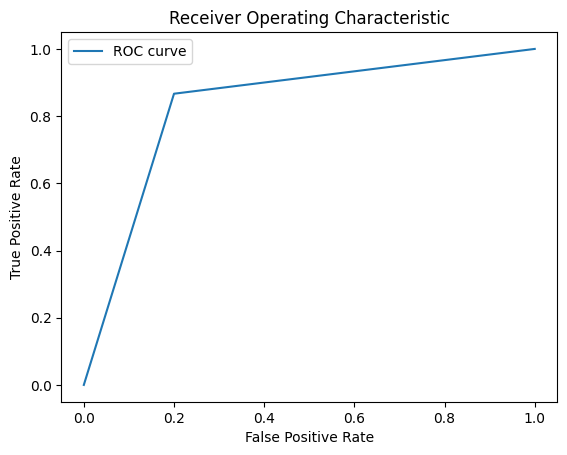

In [ ]:
plot_roc_curve(Y_test, Y_pred)

In [ ]:
Y_pred =clf.predict(X_valid)

In [ ]:
cf_mat = confusion_matrix(Y_valid, Y_pred)
print('Confusion matrix')
print(cf_mat)
print(classification_report(Y_valid, Y_pred))

Confusion matrix
[[60  0]
 [ 0 60]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [ ]:
roc_auc_score(Y_valid, Y_pred)

1.0